In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
from lifelines import KaplanMeierFitter, CoxTimeVaryingFitter

# define filepath to read data
dir_path = '../Data/CMaps/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

# inspect first few rows
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [2]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
print(train.shape)
train[index_names+['RUL']].head()

(20631, 27)


,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [3]:
# clip RUL max as 125 means values in column greater than 125 becomes 125
train['RUL'].clip(upper=125, inplace=True)  

# drop non-informative features, derived from EDA
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']  
drop_labels = setting_names + drop_sensors
train.drop(labels=drop_labels, axis=1, inplace=True)

remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11',
                     's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
train.shape

(20631, 17)

In [4]:
train['breakdown'] = 0
idx_last_record = train.reset_index().groupby(by='unit_nr')['index'].last()  # engines breakdown at the last cycle
train.loc[idx_last_record, 'breakdown'] = 1
train['start'] = train['time_cycles'] - 1 
train.tail() # check results

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4,0,195
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3,0,196
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2,0,197
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1,0,198
20630,100,200,643.85,1600.38,1432.14,550.79,2388.26,9061.48,48.20,519.30,2388.26,8137.33,8.5036,396,38.37,23.0522,0,1,199


In [5]:
cut_off = 200
train_censored = train[train['time_cycles'] <= cut_off].copy()
print(train_censored.shape)
train_censored[train_censored["unit_nr"] == 20].tail()

(18627, 19)


,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start
4129,20,196,642.89,1601.31,1422.88,551.74,2388.21,9063.50,47.88,520.70,2388.24,8143.94,8.4568,394,38.74,23.0713,38,0,195
4130,20,197,642.81,1594.41,1411.02,552.88,2388.15,9066.44,47.99,520.28,2388.21,8140.37,8.4787,395,38.68,23.1269,37,0,196
4131,20,198,642.69,1599.15,1421.81,552.03,2388.19,9062.13,47.90,521.20,2388.18,8139.42,8.4840,394,38.55,23.1019,36,0,197
4132,20,199,643.57,1591.15,1418.58,552.39,2388.15,9066.65,48.06,520.81,2388.18,8142.44,8.5218,394,38.63,23.2158,35,0,198
4133,20,200,642.95,1595.89,1422.65,552.27,2388.15,9067.13,47.86,520.99,2388.15,8143.12,8.4909,395,38.52,23.2385,34,0,199


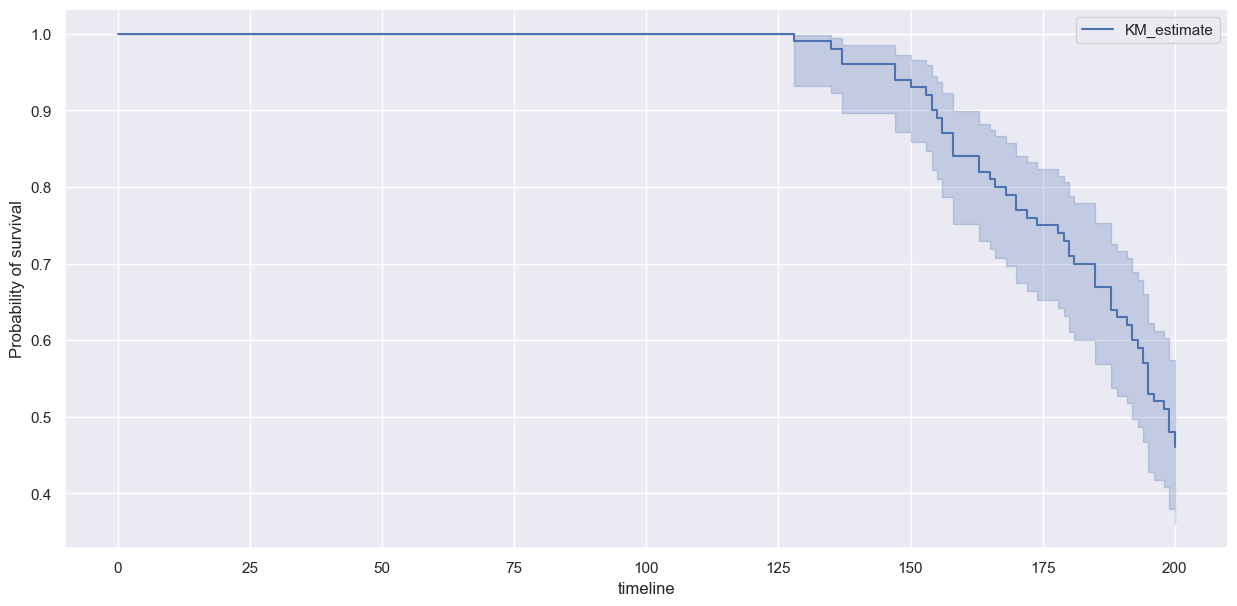

,time_cycles,breakdown
unit_nr,,
96,200,0
97,200,0
98,156,1
99,185,1
100,200,1


In [6]:
data = train_censored[index_names+['breakdown']].groupby('unit_nr').last()
plt.figure(figsize=(15,7))
survival = KaplanMeierFitter()
survival.fit(data['time_cycles'], data['breakdown'])
survival.plot()
plt.ylabel("Probability of survival")
plt.show()
plt.close()
data.tail()

In [7]:
train_cols = index_names + remaining_sensors + ['start', 'breakdown']
predict_cols = ['time_cycles'] + remaining_sensors + ['start', 'breakdown']  # breakdown value will be 0
ctv = CoxTimeVaryingFitter()
ctv.fit(train_censored[train_cols], id_col="unit_nr", event_col='breakdown', 
        start_col='start', stop_col='time_cycles', show_progress=True)

Iteration 1: norm_delta = 0.90312, step_size = 0.95000, ll = -230.78680, newton_decrement = 107.16417, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.71741, step_size = 0.95000, ll = -109.79194, newton_decrement = 23.16688, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.67938, step_size = 0.95000, ll = -81.15203, newton_decrement = 10.29903, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.62899, step_size = 1.00000, ll = -68.53253, newton_decrement = 3.51558, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.30483, step_size = 1.00000, ll = -64.35996, newton_decrement = 0.45281, seconds_since_start = 0.0
Iteration 6: norm_delta = 0.04796, step_size = 1.00000, ll = -63.86912, newton_decrement = 0.00890, seconds_since_start = 0.0
Iteration 7: norm_delta = 0.00100, step_size = 1.00000, ll = -63.86010, newton_decrement = 0.00000, seconds_since_start = 0.0
Iteration 8: norm_delta = 0.00000, step_size = 1.00000, ll = -63.86010, newton_decrement = 0.00000, seconds_sinc

<lifelines.CoxTimeVaryingFitter: fitted with 18627 periods, 100 subjects, 54 events>

<lifelines.CoxTimeVaryingFitter: fitted with 18627 periods, 100 subjects, 54 events>
         event col = 'breakdown'
number of subjects = 100
 number of periods = 18627
  number of events = 54
partial log-likelihood = -63.86
  time fit was run = 2023-01-31 17:09:27 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
s_2         2.05       7.75       0.72             0.64             3.45                 1.90                31.64
s_3         0.07       1.07       0.04            -0.01             0.15                 0.99                 1.16
s_4         0.16       1.18       0.05             0.07             0.26                 1.07                 1.29
s_7        -1.09       0.34       0.50            -2.07            -0.11                 0.13                 0.90
s_8        -5.03       0.01       4.84           -14.51             4.45                 0.00                85.79
s_9        -0.02       0.98       0.04            -0.10             0.05                 0.91                 1.05
s_11        5.12     167.43       1.70             1.78             8.46                 5.95              4714.95
s_12       -1.14       0.32       0.53            -2.17            -0.10                 0.11                 0.90
s_13       12.90   3.99e+05       5.51             2.09            23.70                 8.09             1.97e+10
s_14        0.04       1.04       0.04            -0.04             0.12                 0.96                 1.13
s_15        5.07     159.96       9.53           -13.61            23.76                 0.00             2.09e+10
s_17        0.41       1.51       0.20             0.01             0.81                 1.01                 2.25
s_20       -5.13       0.01       2.02            -9.09            -1.17                 0.00                 0.31
s_21       -4.23       0.01       2.67            -9.46             1.01                 0.00                 2.75

            cmp to     z      p   -log2(p)
covariate                                 
s_2           0.00  2.85 <0.005       7.84
s_3           0.00  1.73   0.08       3.57
s_4           0.00  3.49 <0.005      11.03
s_7           0.00 -2.17   0.03       5.06
s_8           0.00 -1.04   0.30       1.74
s_9           0.00 -0.58   0.56       0.82
s_11          0.00  3.01 <0.005       8.56
s_12          0.00 -2.15   0.03       4.99
s_13          0.00  2.34   0.02       5.69
s_14          0.00  0.95   0.34       1.54
s_15          0.00  0.53   0.59       0.75
s_17          0.00  2.03   0.04       4.56
s_20          0.00 -2.54   0.01       6.49
s_21          0.00 -1.58   0.11       3.14
---
Partial AIC = 155.72
log-likelihood ratio test = 333.85 on 14 df
-log2(p) of ll-ratio test = 205.97

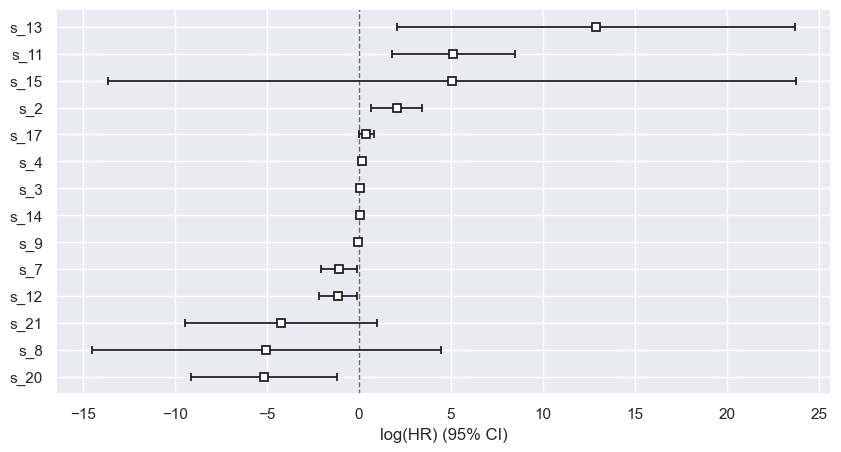

In [8]:
ctv.print_summary()
plt.figure(figsize=(10,5))
ctv.plot()
plt.show()
plt.close()

In [9]:
df = train_censored.groupby("unit_nr").last()
df = df[df['breakdown'] == 0]  # get engines from dataset which are still functioning so we can predict their RUL
df_to_predict = df.copy().reset_index()
# predictions = pd.DataFrame(ctv.predict_log_partial_hazard(df_to_predict[predict_cols]), index=df_to_predict.index)
predictions = ctv.predict_log_partial_hazard(df_to_predict[predict_cols]).to_frame()
predictions.rename(columns={0: "predictions"}, inplace=True)
df_last = train.groupby('unit_nr').last()
predictions['RUL'] = df_to_predict['RUL']
predictions.head(10)

,predictions,RUL
0,-1.128757,87
1,-1.607369,69
2,3.073379,59
3,21.145492,1
4,11.751951,22
5,4.391817,40
6,14.439742,7
7,20.540832,9
8,-3.512471,76
9,10.624723,34


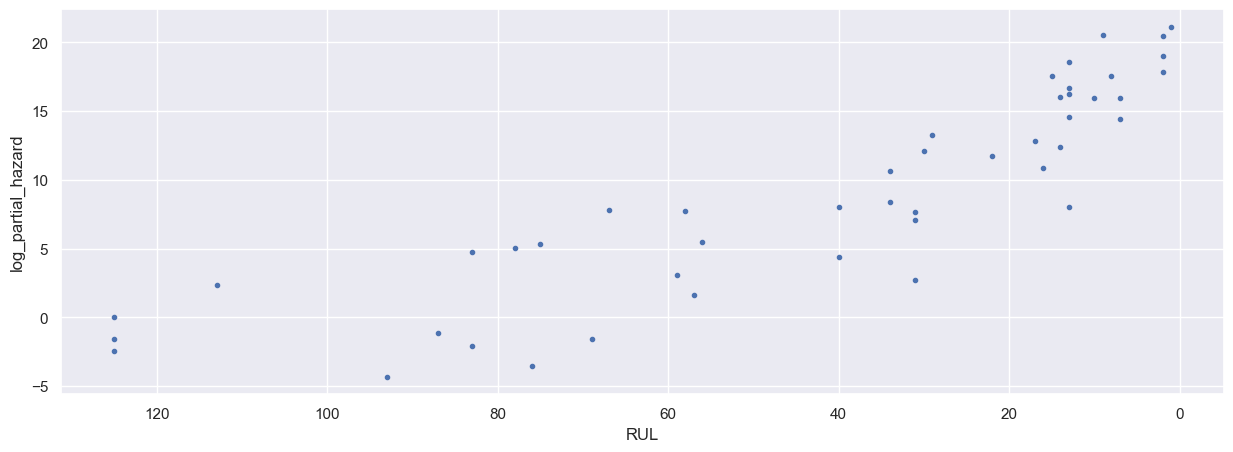

In [10]:
plt.figure(figsize=(15,5))
plt.plot(predictions['RUL'], predictions['predictions'], '.b')
xlim = plt.gca().get_xlim()
plt.xlim(xlim[1], xlim[0])
plt.xlabel('RUL')
plt.ylabel('log_partial_hazard')
plt.show()

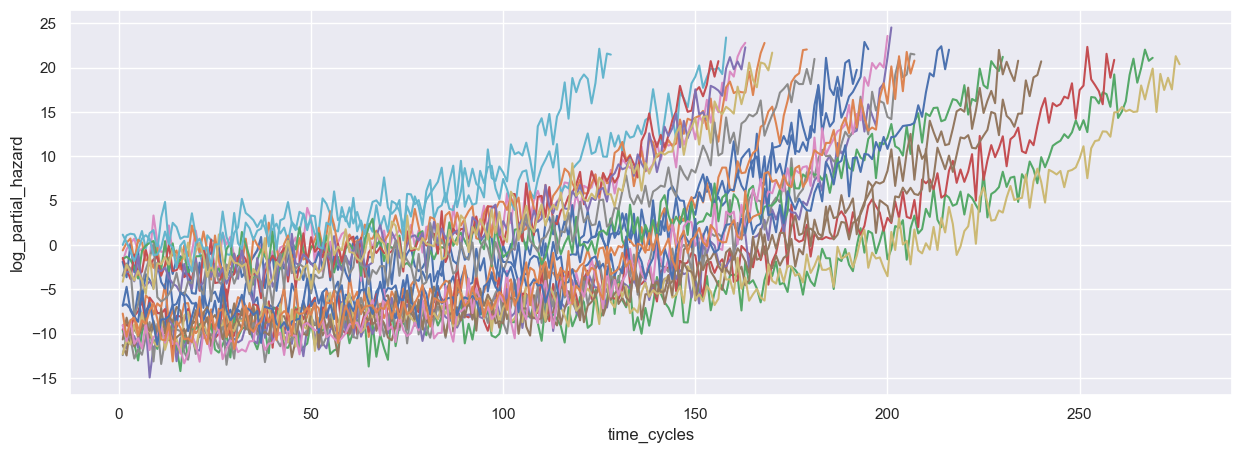

In [11]:
# now lets look at some hazard trajectories
X = train.loc[train['unit_nr'].isin(df_to_predict.index)]
X_unique = len(X['unit_nr'].unique())

plt.figure(figsize=(15,5))

for i in range(1, X_unique, 2):
    X_sub = X.loc[X['unit_nr'] == i]
    predictions = ctv.predict_partial_hazard(X_sub).values
    plt.plot(X_sub['time_cycles'].values, np.log(predictions))

plt.xlabel('time_cycles')
plt.ylabel('log_partial_hazard')
plt.show()

In [12]:
df_hazard = train_censored.copy().reset_index()
df_hazard['hazard'] = ctv.predict_log_partial_hazard(df_hazard)
df_hazard.head()

,index,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,...,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start,hazard
0,0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,...,2388.02,8138.62,8.4195,392,39.06,23.4190,125,0,0,-6.856341
1,1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,...,2388.07,8131.49,8.4318,392,39.00,23.4236,125,0,1,-4.700971
2,2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,...,2388.03,8133.23,8.4178,390,38.95,23.3442,125,0,2,-7.370774
3,3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,...,2388.08,8133.83,8.3682,392,38.88,23.3739,125,0,3,-8.140738
4,4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,...,2388.04,8133.80,8.4294,393,38.90,23.4044,125,0,4,-5.260691


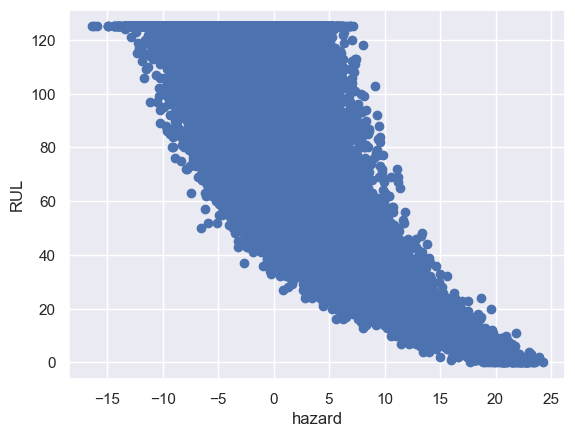

In [13]:
plt.scatter(df_hazard['hazard'], df_hazard['RUL'])
plt.xlabel('hazard')
plt.ylabel('RUL')
plt.show()

In [14]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

def exponential_model(z, a, b):
    return a * np.exp(-b * z)
  
popt, pcov = curve_fit(exponential_model, df_hazard['hazard'], df_hazard['RUL'])
print(popt)

[8.85954699e+01 4.35302167e-02]


In [15]:
test

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [16]:
# prep test set
test = test.drop(labels=drop_labels, axis=1)
test['breakdown'] = 0
test['start'] = test['time_cycles'] - 1

# predict and evaluate
y_hat = exponential_model(df_hazard['hazard'], *popt)
evaluate(df_hazard['RUL'], y_hat, 'train')

y_pred = ctv.predict_log_partial_hazard(test.groupby('unit_nr').last())
y_hat = exponential_model(y_pred, *popt)
evaluate(y_test, y_hat)

train set RMSE:26.30285842224382, R2:0.5487597218187112
test set RMSE:27.135244171016517, R2:0.5736091038833007


In [17]:
ctv2 = CoxTimeVaryingFitter()
ctv2.fit(train[train_cols], id_col="unit_nr", event_col='breakdown', 
         start_col='start', stop_col='time_cycles', show_progress=True)

train['hazard'] = ctv2.predict_log_partial_hazard(train)
popt2, pcov2 = curve_fit(exponential_model, train['hazard'], train['RUL'])

y_hat = exponential_model(train['hazard'], *popt2)
evaluate(train['RUL'], y_hat, 'train')

y_pred = ctv2.predict_log_partial_hazard(test.groupby('unit_nr').last())
y_hat = exponential_model(y_pred, *popt2)
evaluate(y_test, y_hat)

Iteration 1: norm_delta = 1.00314, step_size = 0.95000, ll = -363.73938, newton_decrement = 168.94519, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.23297, step_size = 0.95000, ll = -196.95744, newton_decrement = 65.27103, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.74854, step_size = 0.95000, ll = -141.32406, newton_decrement = 25.30741, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.72741, step_size = 0.93100, ll = -129.43964, newton_decrement = 16.79179, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.22965, step_size = 1.00000, ll = -115.92018, newton_decrement = 1.13231, seconds_since_start = 0.0
Iteration 6: norm_delta = 0.04043, step_size = 1.00000, ll = -114.78357, newton_decrement = 0.01240, seconds_since_start = 0.1
Iteration 7: norm_delta = 0.00056, step_size = 1.00000, ll = -114.77107, newton_decrement = 0.00000, seconds_since_start = 0.1
Iteration 8: norm_delta = 0.00000, step_size = 1.00000, ll = -114.77106, newton_decrement = 0.00000, secon